In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats


In [2]:
rolling_ratings = pd.read_csv('data/rolling_period_ratings_stats.csv')
rolling_ratings['reviewDateTime'] = pd.to_datetime(rolling_ratings['reviewDateTime'])

filters = pd.read_pickle('data/groupings/filters.pkl')
by_employee = pd.read_csv('data/groupings/by_employee.csv')
by_industry = pd.read_csv('data/groupings/by_industry.csv')
by_revenue = pd.read_csv('data/groupings/by_revenue.csv')

not_employed = pd.read_csv('data/not_employed_OLS.csv')
not_employed['reviewDateTime'] = pd.to_datetime(not_employed['reviewDateTime'])
employed = pd.read_csv('data/employed_OLS.csv')
employed['reviewDateTime'] = pd.to_datetime(employed['reviewDateTime'])

In [3]:
company = pd.read_parquet('data/company_overview_cleaned.parquet')
glassd_classification = pd.read_parquet('data/glassd_classification_cleaned.parquet')
glassd_classification['reviewDateTime'] = glassd_classification.index
glassd_classification['reviewDateTime'] = glassd_classification['reviewDateTime'].apply(lambda x: x.date().strftime("%Y-%m-%d"))
# text = pd.read_parquet('/home/group3/glassdoor/glassd_review_internal_data_2024-03-19.parquet')
# stock_monthly = pd.read_csv('/home/group3/group3/Finalized/data/stock_monthly.csv')
# stock_monthly['date'] = pd.to_datetime(stock_monthly['date'])
# rolling_ret = pd.read_csv('/home/group3/group3/Finalized/data/rolling_future_ret.csv')
# rolling_ret['date'] = pd.to_datetime(rolling_ret['date'])
# rolling_ratings = pd.read_csv('/home/group3/group3/Finalized/data/rolling_period_ratings_stats.csv')
# rolling_ratings['reviewDateTime'] = pd.to_datetime(rolling_ratings['reviewDateTime'])
# rolling_ret_rating = pd.merge(rolling_ratings,rolling_ret, left_on=['ticker','reviewDateTime'], right_on=['ticker','date'])

In [4]:
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
filtered_df = filtered_df.drop_duplicates()

<Axes: >

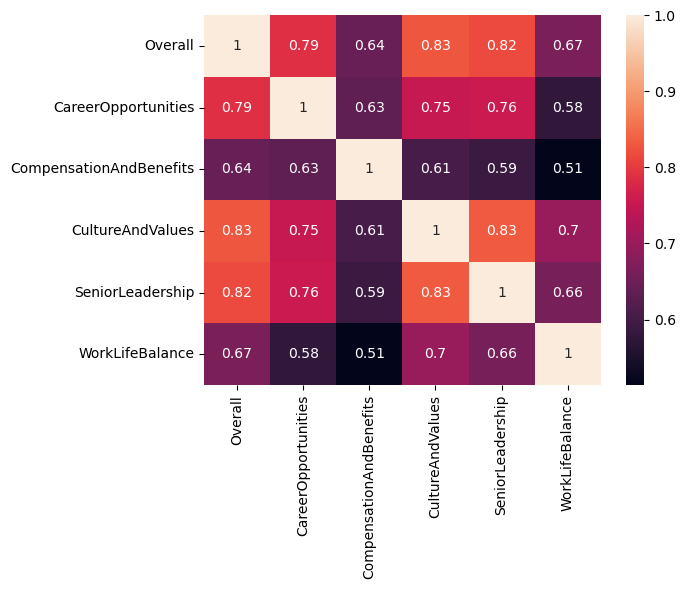

In [5]:
# get correlation matrix

cm = rolling_ratings.filter(like='1_').filter(like='_mean').drop('1_ratingDiversityAndInclusion_mean',axis=1)
cm.columns = cm.columns.str.removeprefix('1_rating').str.removesuffix('_mean')
cm = cm.corr()

sns.heatmap(cm,annot=True)

In [25]:
cm.mean().mean()

0.7426237522383142

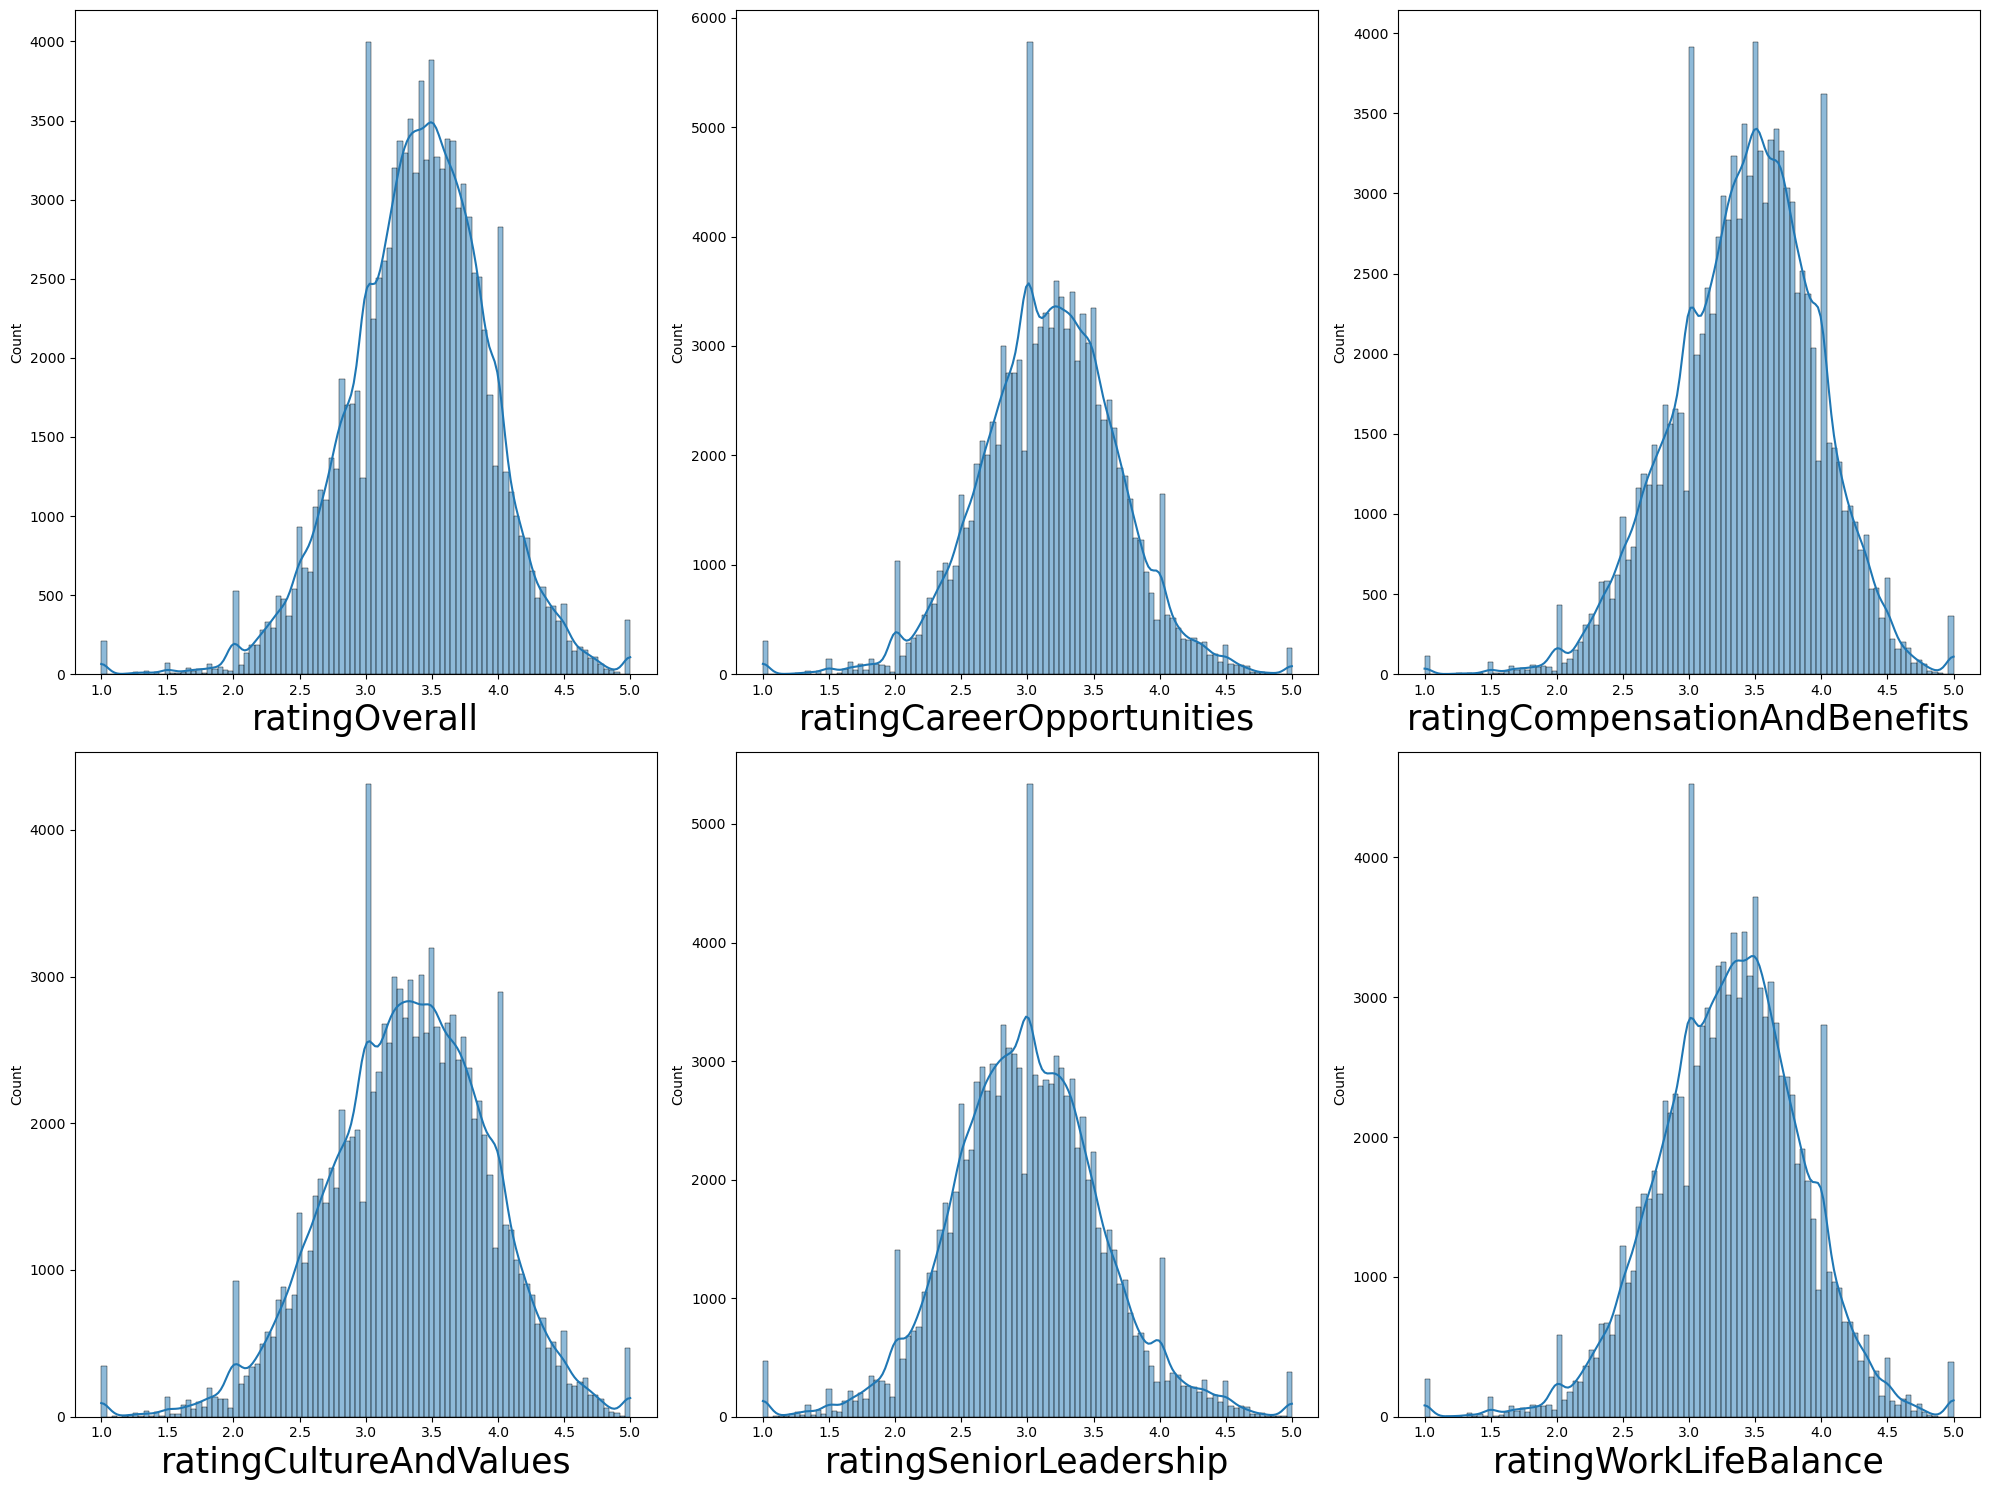

In [86]:
ratings = filtered_df.filter(like='12_').filter(like='_mean').drop('12_ratingDiversityAndInclusion_mean',axis=1)
# ratings.columns = cm.columns.str.removeprefix('12_').str.removesuffix('_mean')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
axes = axes.flatten()  

for i, ax in enumerate(axes):
    if i >= len(ratings):
        continue
    ax.set_xlabel(ratings.columns[i][3:-5], fontsize=25)
    sns.histplot(ratings[ratings.columns[i]], bins=100, ax=ax, kde=True)
    
plt.tight_layout()
plt.show()

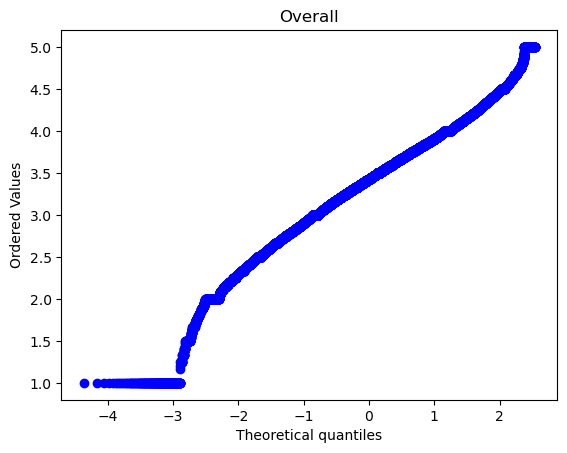

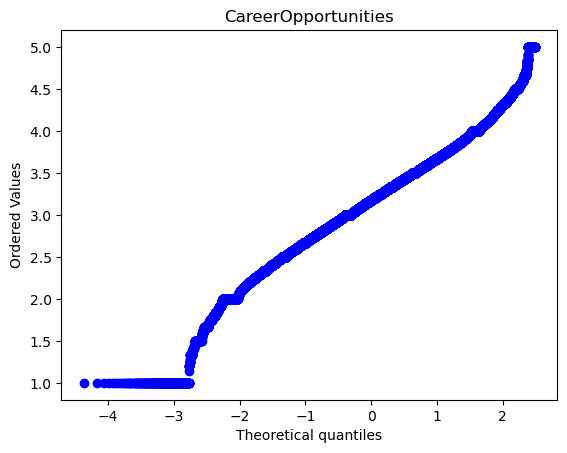

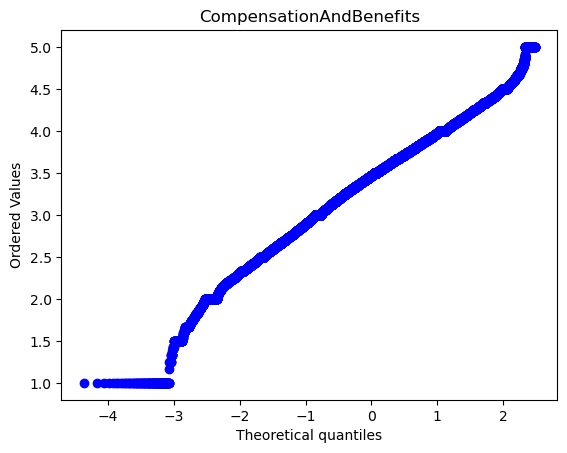

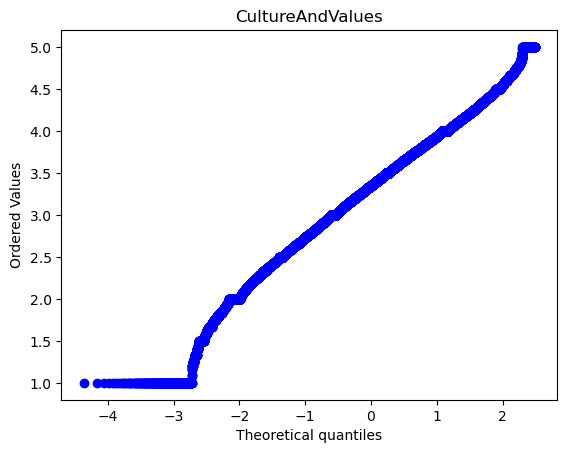

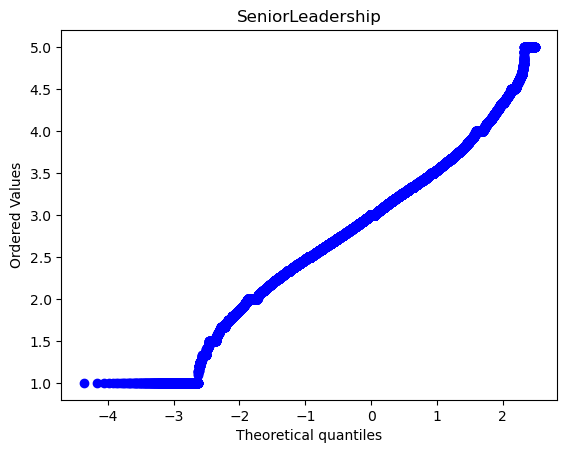

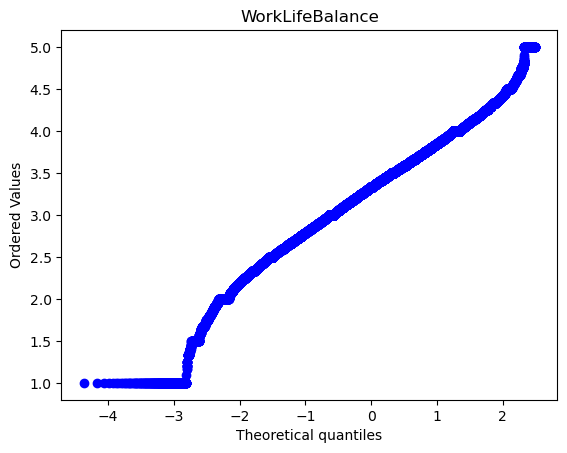

In [18]:
for i in ratings.columns:
    stats.probplot(ratings[i], dist="norm", plot=plt)
    plt.title(i)
    plt.show()

<Axes: xlabel='12_ratingOverall_mean', ylabel='Count'>

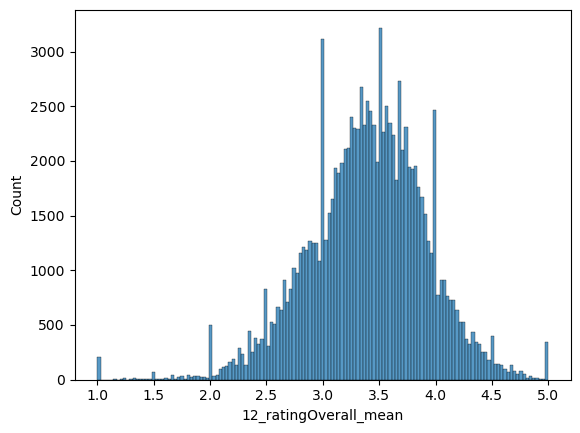

In [12]:
sns.histplot(filtered_df['12_ratingOverall_mean'])

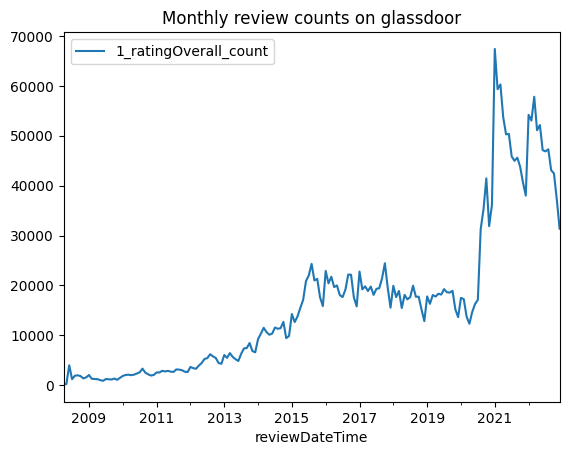

In [34]:
rolling_ratings[['reviewDateTime','1_ratingOverall_count']].groupby('reviewDateTime').sum().plot()
plt.title('Monthly review counts on glassdoor')
plt.show()

In [88]:
columns = ['ratingOverall', 'ratingCompensationAndBenefits', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
           'ratingCareerOpportunities', 'ratingCareerOpportunities',  'ratingDiversityAndInclusion']
yearly_agg = rolling_ratings.set_index('reviewDateTime').filter(like='1_').resample('Y').sum()

yearly_mean = []
for i in columns:
    yearly_mean.append(yearly_agg[f"1_{i}_total"]/yearly_agg[f"1_{i}_count"])

yearly_avg = pd.DataFrame(yearly_mean).T
yearly_avg.columns = columns

Text(0.5, 1.0, 'Yearly Average Scores')

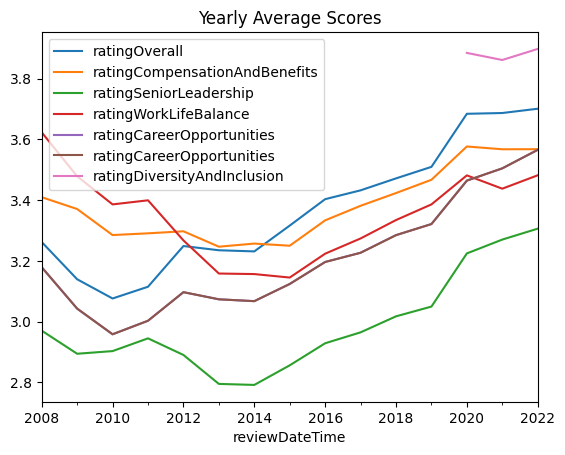

In [95]:
yearly_avg.plot()
plt.title("Yearly Average Scores")

In [56]:
ser = monthly_agg[f"1_{i}_total"]/monthly_agg[f"1_{i}_count"]

In [61]:
ser[ser.index > '2014-01-01']

reviewDateTime
2014-01-31    3.118418
2014-02-28    3.087874
2014-03-31    3.065986
2014-04-30    3.070959
2014-05-31    3.038390
                ...   
2022-08-31    3.544341
2022-09-30    3.564884
2022-10-31    3.572957
2022-11-30    3.593857
2022-12-31    3.553002
Freq: ME, Length: 108, dtype: float64

In [63]:
columns = ['ratingOverall', 'ratingCompensationAndBenefits', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
           'ratingCareerOpportunities', 'ratingCareerOpportunities']
monthly_agg = rolling_ratings.set_index('reviewDateTime').filter(like='1_').resample('M').sum()

monthly_mean = []
for i in columns:
    m = monthly_agg[f"1_{i}_total"]/monthly_agg[f"1_{i}_count"]
    monthly_mean.append(m[m.index>'2014-01-01'])

monthly_avg = pd.DataFrame(monthly_mean).T
monthly_avg.columns = columns

/var/folders/fm/rwn89n9x1b94vk3rbr72zvtw0000gn/T/ipykernel_20596/3849310668.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = rolling_ratings.set_index('reviewDateTime').filter(like='1_').resample('M').sum()


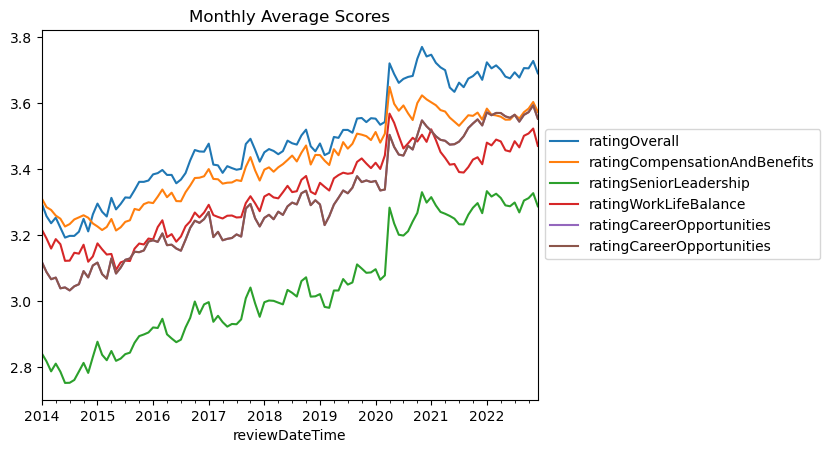

In [70]:
monthly_avg.plot()
plt.title("Monthly Average Scores")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))

In [71]:
columns = ['ratingOverall', 'ratingCompensationAndBenefits', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
           'ratingCareerOpportunities', 'ratingCareerOpportunities']
monthly_agg = not_employed.set_index('reviewDateTime').filter(like='1_').resample('M').sum()

monthly_mean = []
for i in columns:
    m = monthly_agg[f"1_{i}_total"]/monthly_agg[f"1_{i}_count"]
    monthly_mean.append(m[m.index>'2014-01-01'])

monthly_avg = pd.DataFrame(monthly_mean).T
monthly_avg.columns = columns

/var/folders/fm/rwn89n9x1b94vk3rbr72zvtw0000gn/T/ipykernel_20596/1722006007.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = not_employed.set_index('reviewDateTime').filter(like='1_').resample('M').sum()


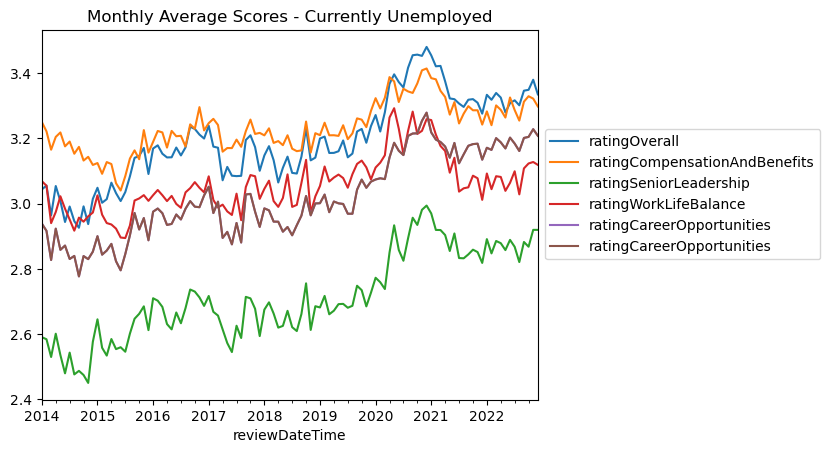

In [72]:
monthly_avg.plot()
plt.title("Monthly Average Scores - Currently Unemployed")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))

In [73]:
columns = ['ratingOverall', 'ratingCompensationAndBenefits', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
           'ratingCareerOpportunities', 'ratingCareerOpportunities']
monthly_agg = employed.set_index('reviewDateTime').filter(like='1_').resample('M').sum()

monthly_mean = []
for i in columns:
    m = monthly_agg[f"1_{i}_total"]/monthly_agg[f"1_{i}_count"]
    monthly_mean.append(m[m.index>'2014-01-01'])

monthly_avg = pd.DataFrame(monthly_mean).T
monthly_avg.columns = columns

/var/folders/fm/rwn89n9x1b94vk3rbr72zvtw0000gn/T/ipykernel_20596/247430925.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = employed.set_index('reviewDateTime').filter(like='1_').resample('M').sum()


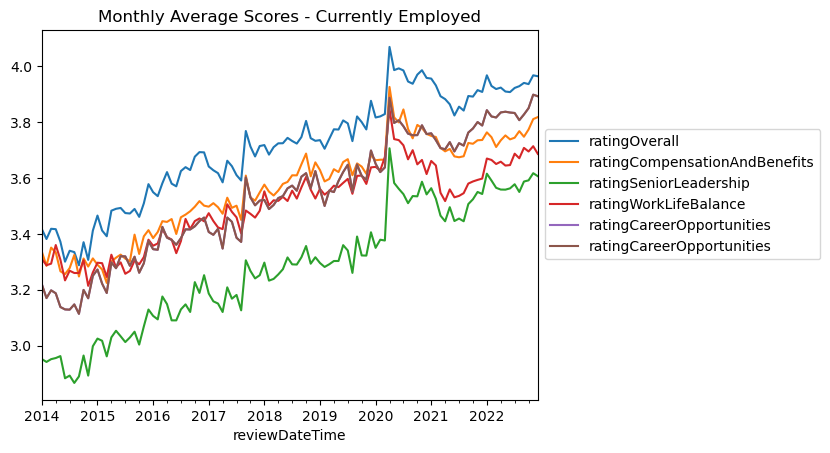

In [75]:
monthly_avg.plot()
plt.title("Monthly Average Scores - Currently Employed")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))

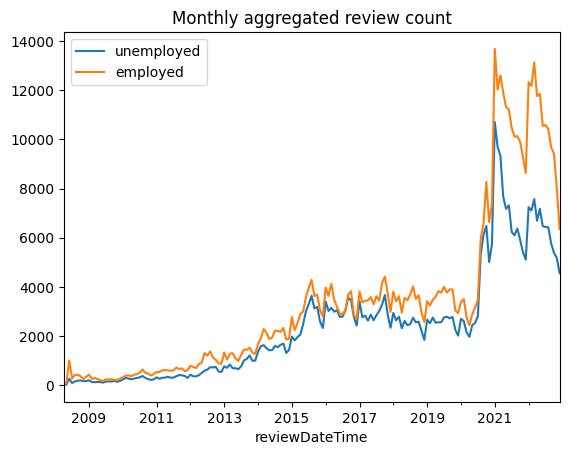

In [146]:
not_employed.set_index('reviewDateTime')['1_ratingOverall_count'].resample('M').sum().plot(label='unemployed')
employed.set_index('reviewDateTime')['1_ratingOverall_count'].resample('M').sum().plot(label='employed')
plt.legend()
plt.title("Monthly aggregated review count")
plt.show()

In [50]:
for i in glassd_classification.filter(like='rating').columns:
    print(f"Missing value for {i}: {len(glassd_classification[glassd_classification[i]==0])} ({len(glassd_classification[glassd_classification[i]==0])/len(glassd_classification): .3f})")

Missing value for ratingOverall: 0 ( 0.000)
Missing value for ratingCareerOpportunities: 791133 ( 0.187)
Missing value for ratingCompensationAndBenefits: 800743 ( 0.190)
Missing value for ratingCultureAndValues: 959833 ( 0.227)
Missing value for ratingSeniorLeadership: 843583 ( 0.200)
Missing value for ratingWorkLifeBalance: 810539 ( 0.192)
Missing value for ratingDiversityAndInclusion: 2620511 ( 0.621)
Missing value for ratingBusinessOutlook: 0 ( 0.000)
Missing value for ratingCeo: 0 ( 0.000)
Missing value for ratingRecommendToFriend: 0 ( 0.000)


# NLP

In [20]:
nlp_rolling_ratings = pd.read_csv('data/nlp_rollingret.csv')
nlp_rolling_ratings['reviewDateTime'] = pd.to_datetime(nlp_rolling_ratings['reviewDateTime'])

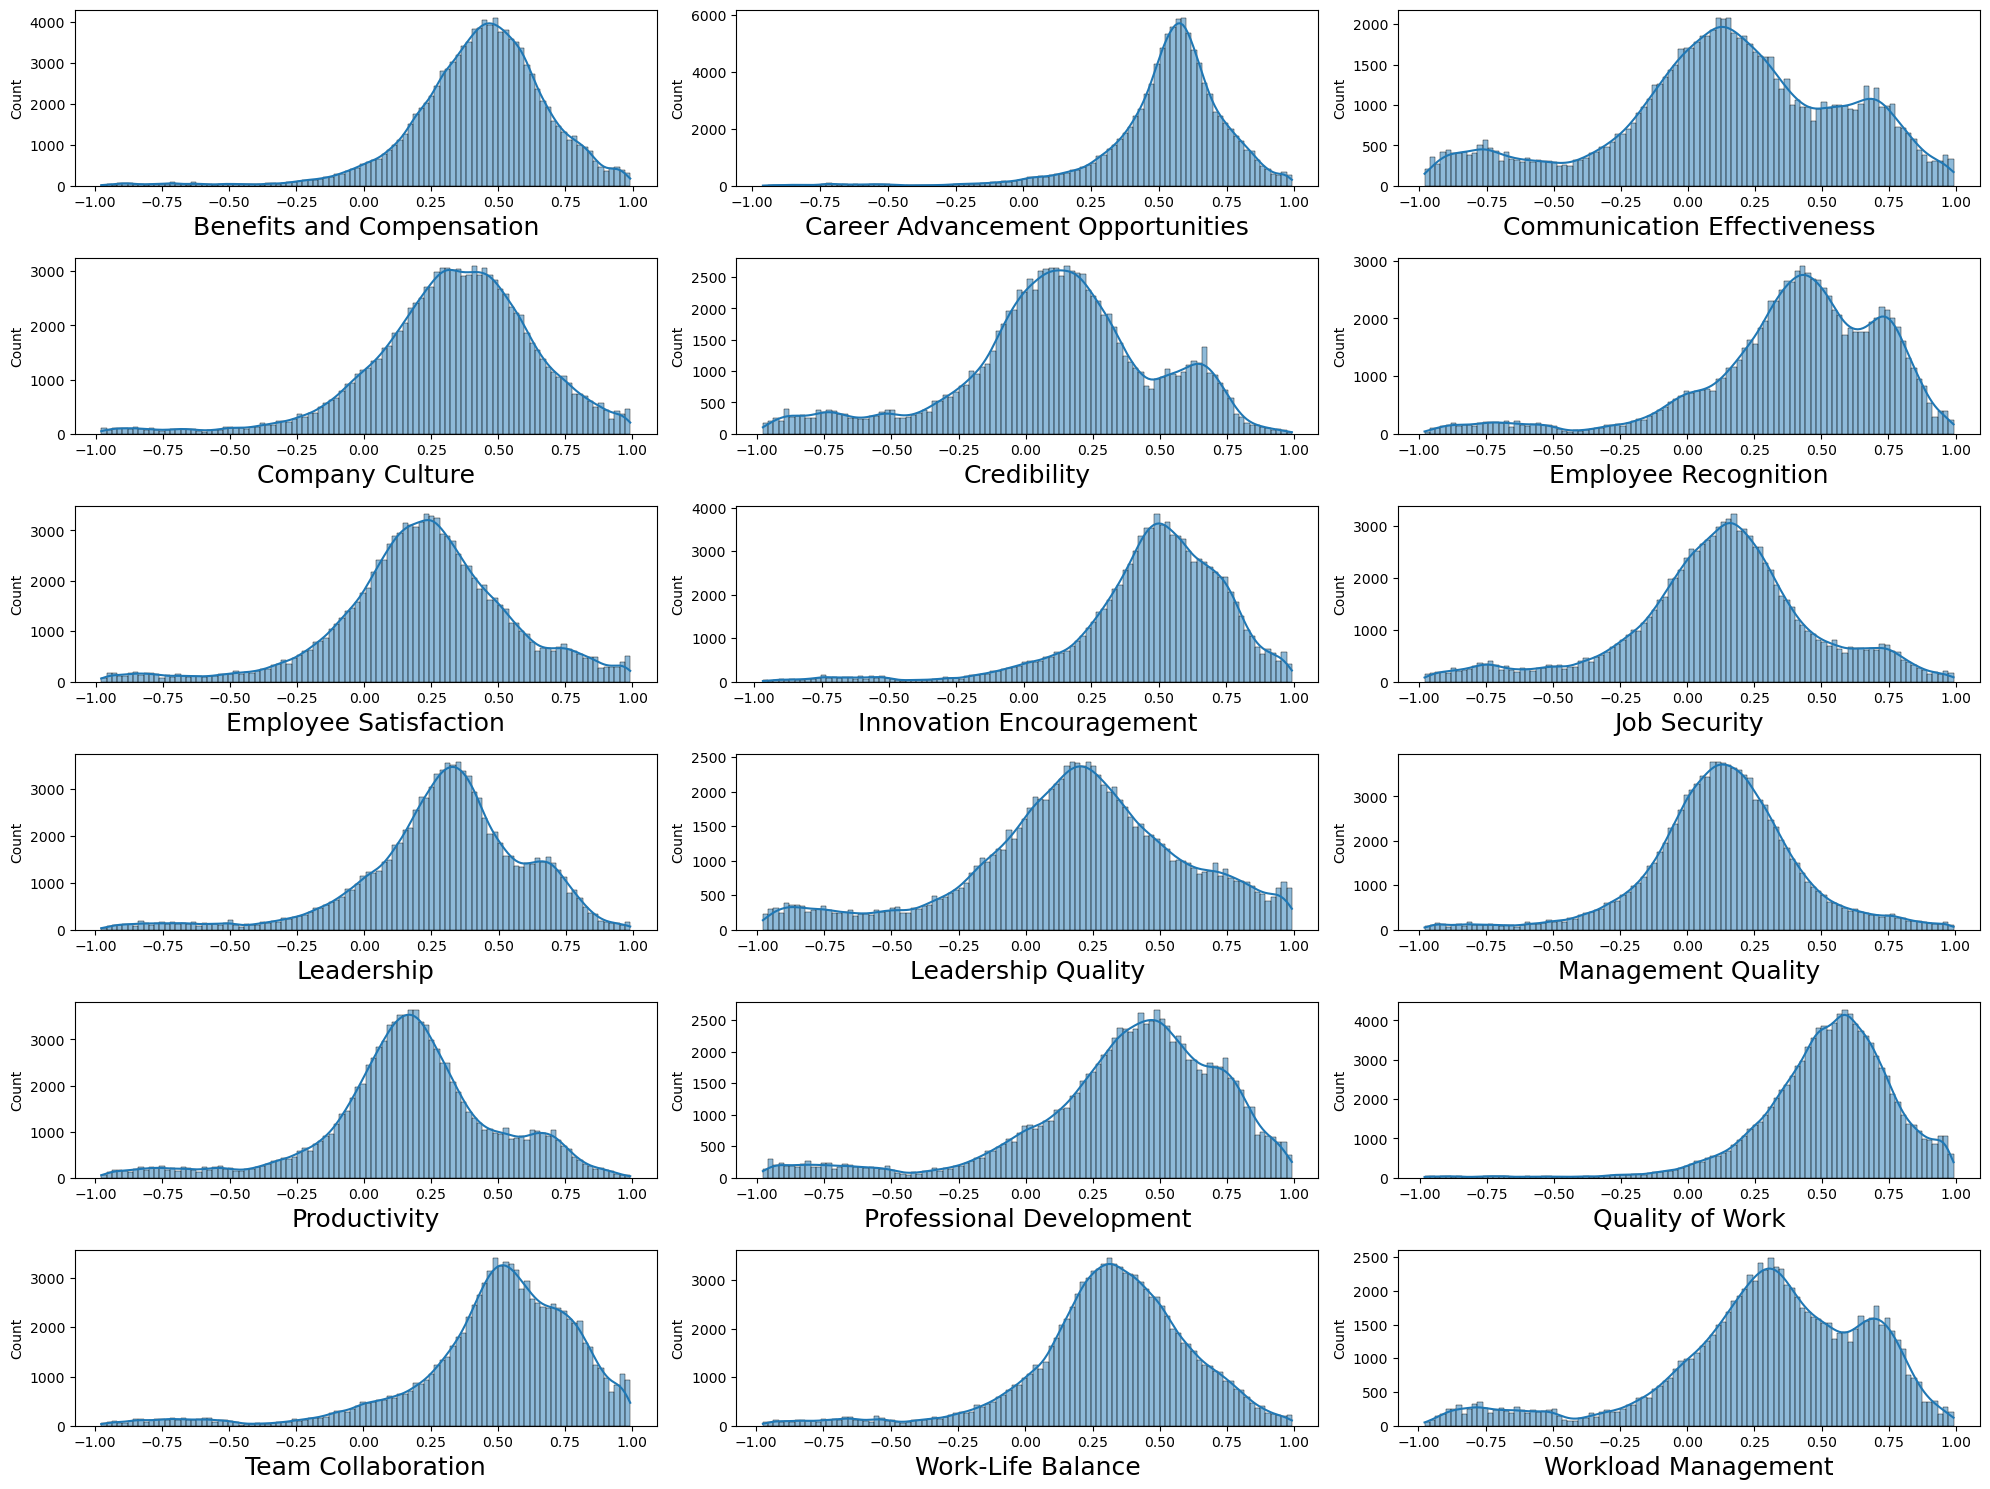

In [70]:
features = [i for i in nlp_rolling_ratings.filter(like='12_').filter(like='_mean').columns]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Create a histogram for each dataset
for i, ax in enumerate(axes):
    if i >= len(features):
        continue
    ax.set_xlabel(features[i][3:-5], fontsize=18)
    sns.histplot(nlp_rolling_ratings[features[i]], bins=100, ax=ax, kde=True)
    
plt.tight_layout()
plt.show()

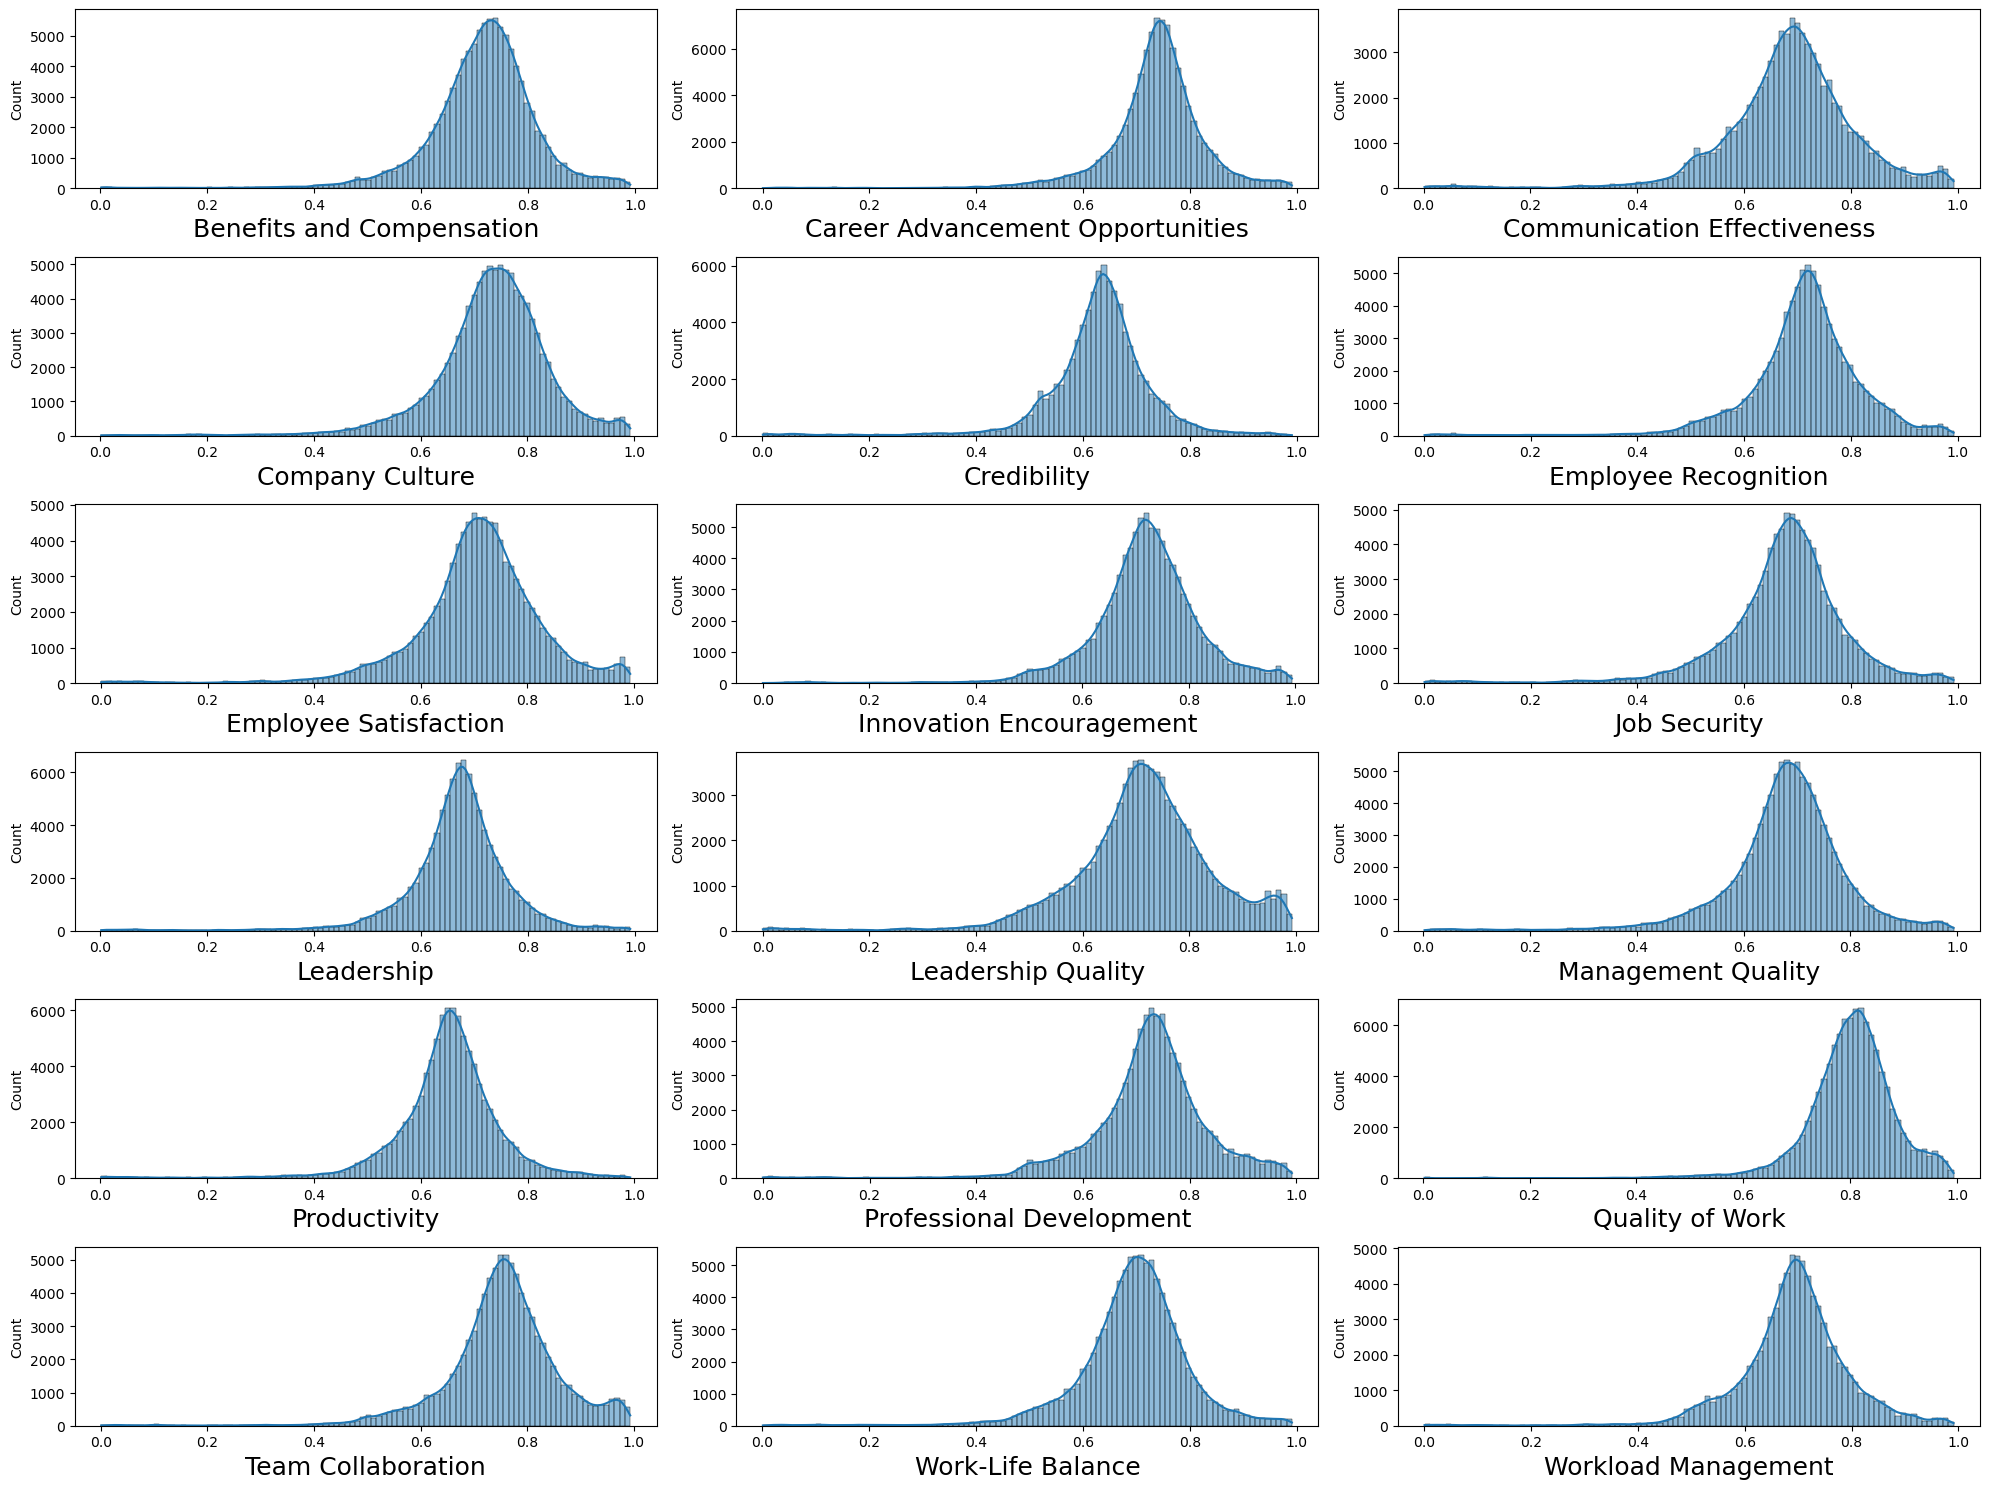

In [68]:
features = [i for i in nlp_rolling_ratings.filter(like='12_').filter(like='_posmean').columns]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Create a histogram for each dataset
for i, ax in enumerate(axes):
    if i >= len(features):
        continue
    ax.set_xlabel(features[i][3:-8], fontsize=18)
    sns.histplot(nlp_rolling_ratings[features[i]], bins=100, ax=ax, kde=True)
    
plt.tight_layout()
plt.show()

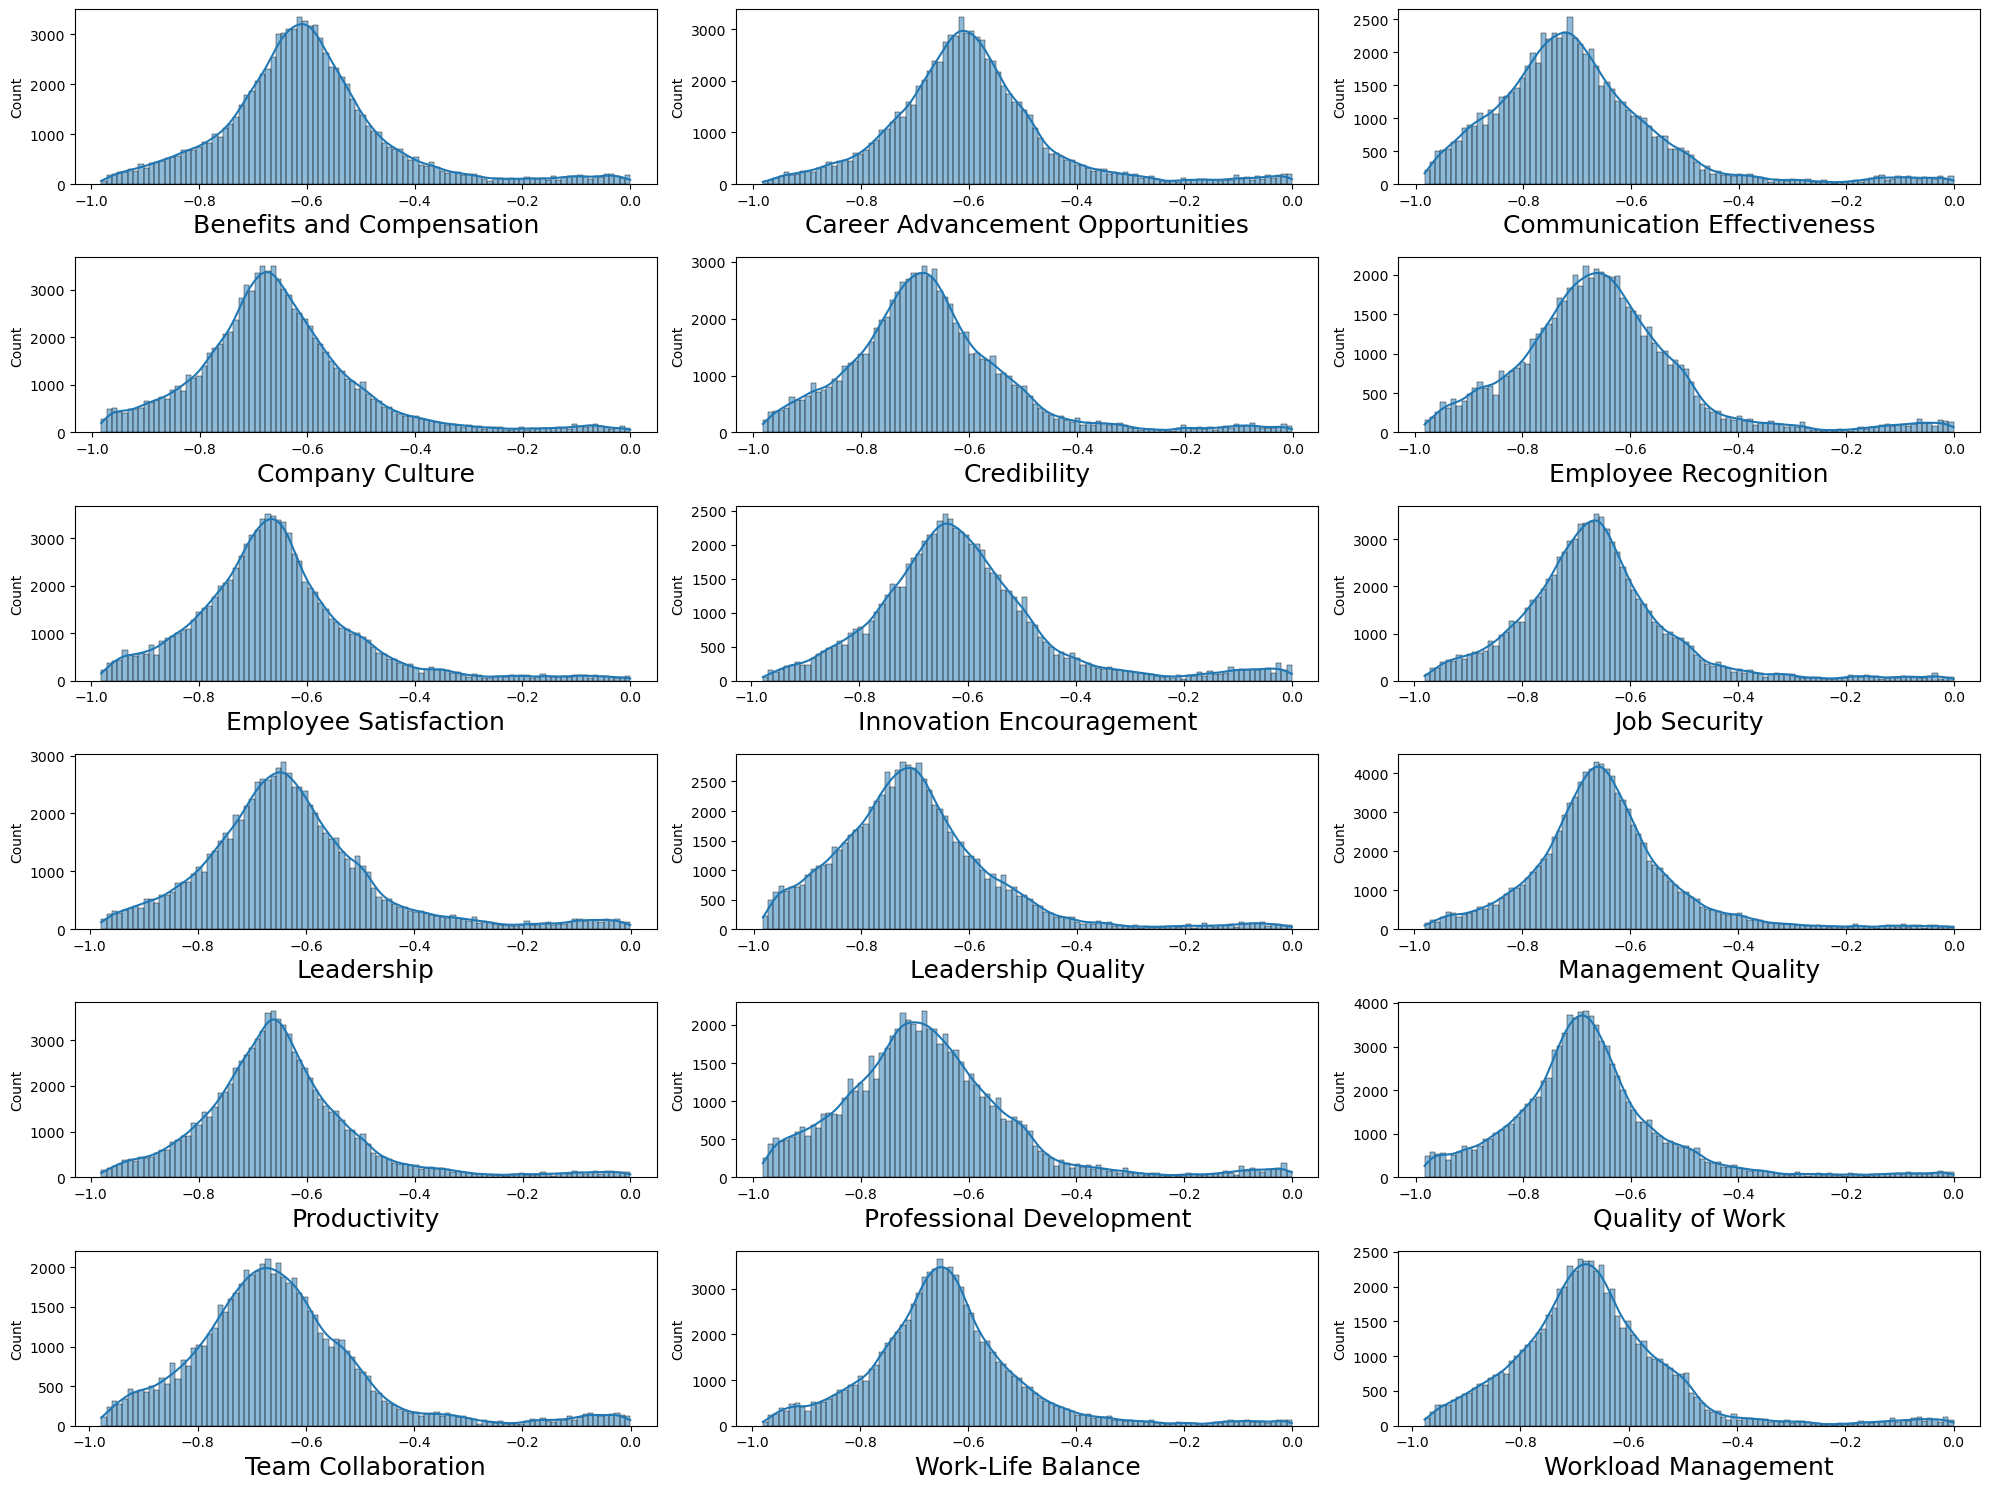

In [67]:
features = [i for i in nlp_rolling_ratings.filter(like='12_').filter(like='_negmean').columns]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Create a histogram for each dataset
for i, ax in enumerate(axes):
    if i >= len(features):
        continue
    ax.set_xlabel(features[i][3:-8], fontsize=18)
    sns.histplot(nlp_rolling_ratings[features[i]], bins=100, ax=ax, kde=True)
    
plt.tight_layout()
plt.show()

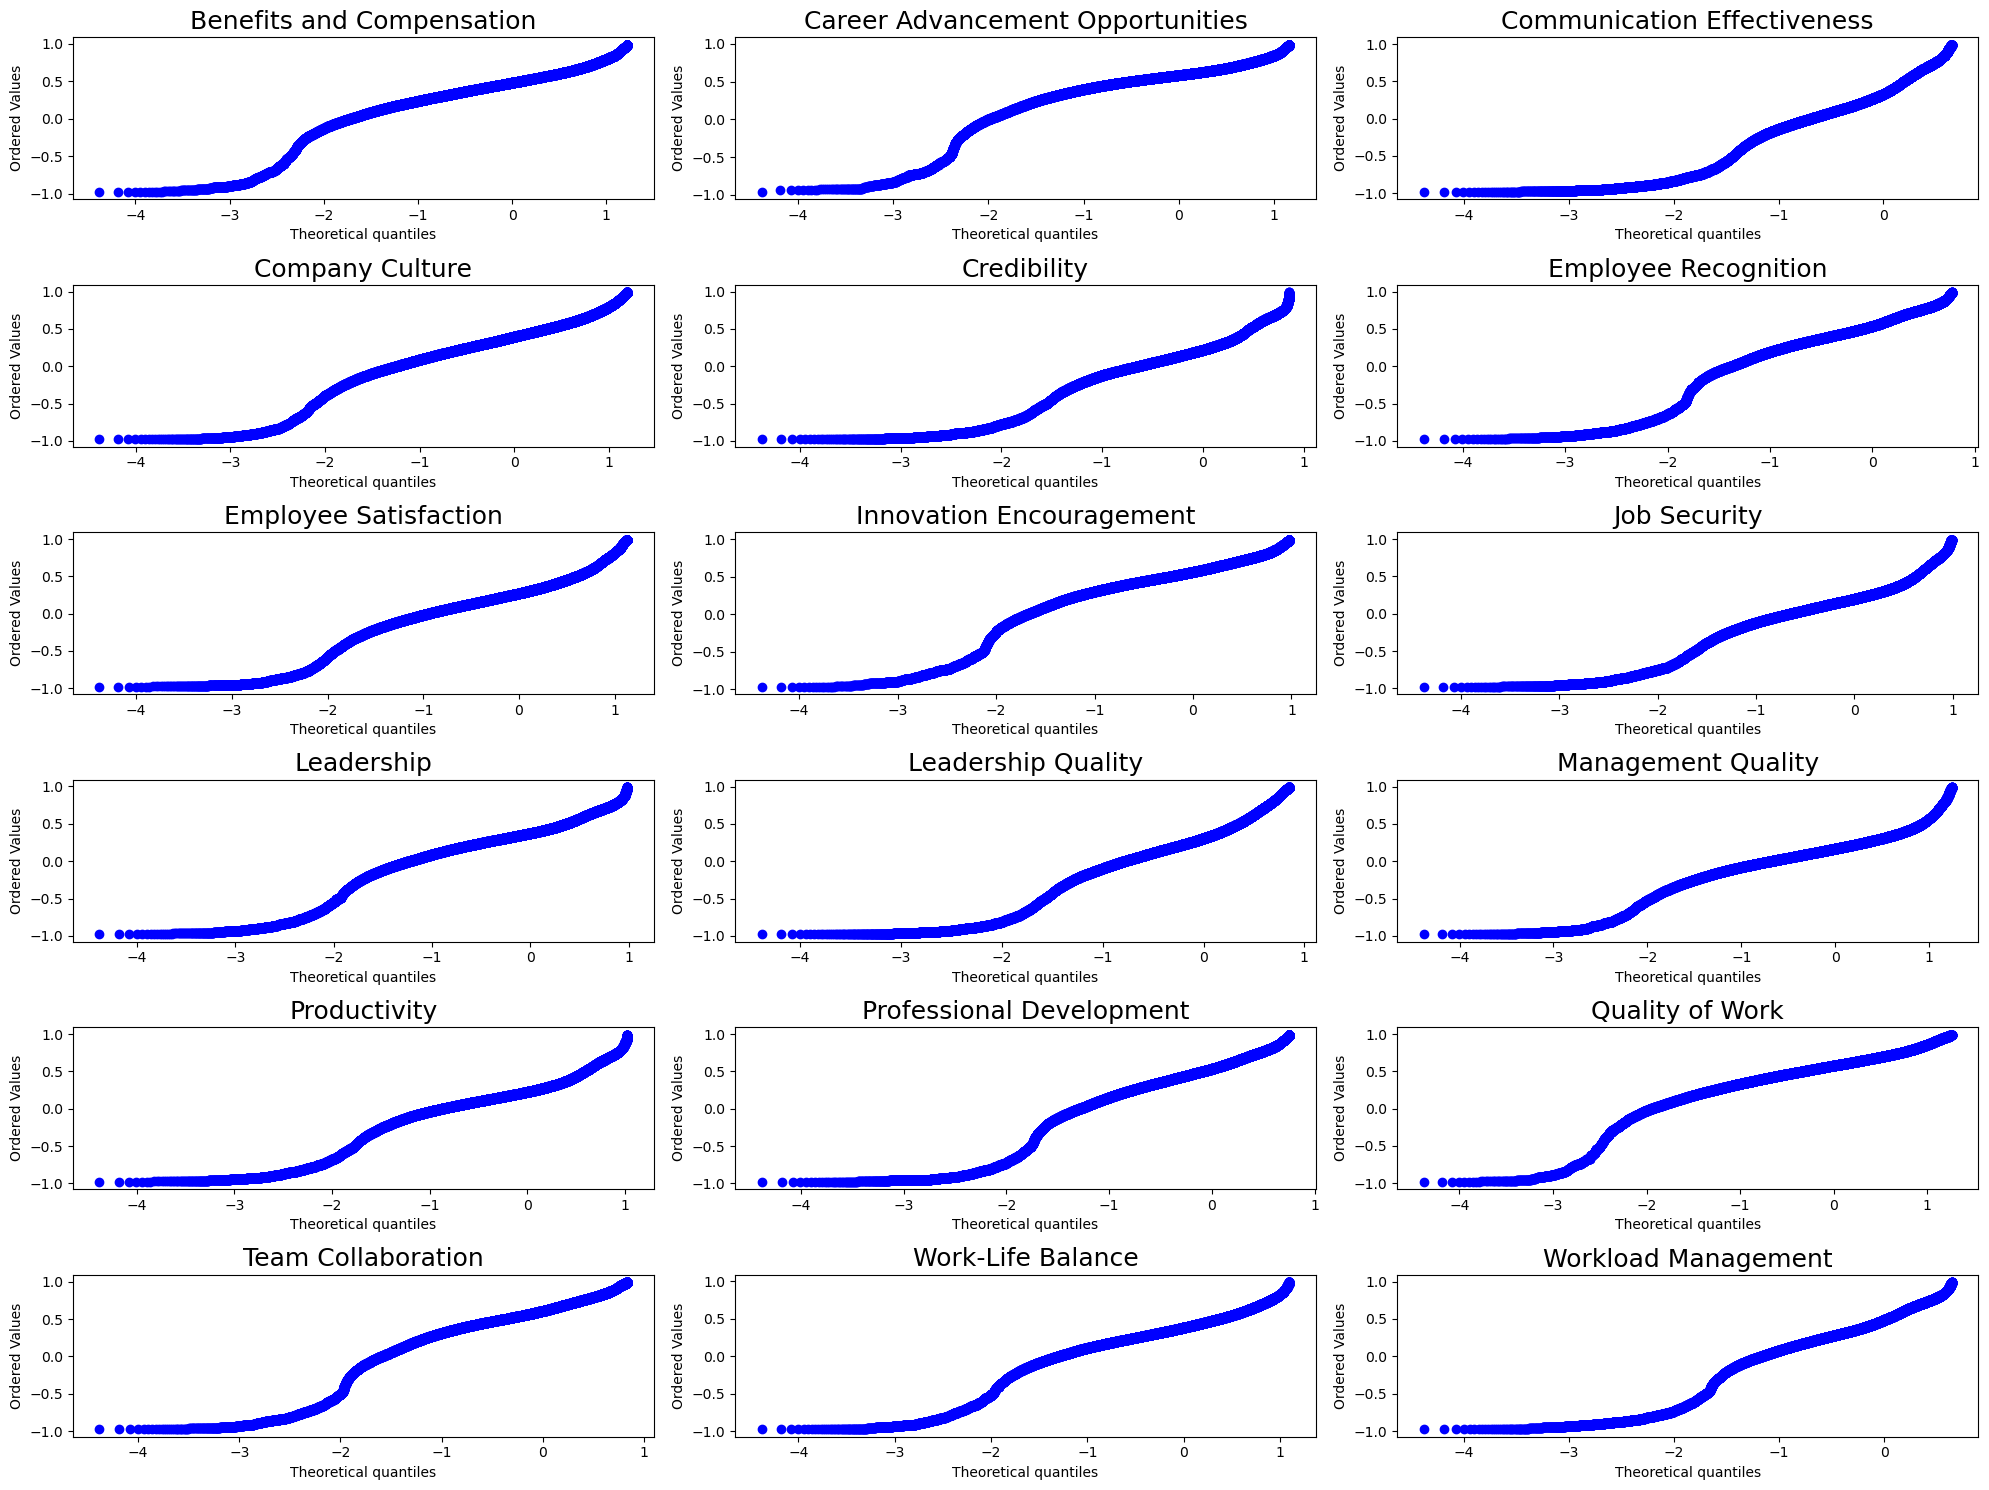

In [77]:
features = [i for i in nlp_rolling_ratings.filter(like='12_').filter(like='_mean').columns]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Create a histogram for each dataset
for i, ax in enumerate(axes):
    if i >= len(features):
        continue
    stats.probplot(nlp_rolling_ratings[features[i]], dist="norm", plot=ax)
    ax.set_title(features[i][3:-5], fontsize=18)

    # sns.histplot(nlp_rolling_ratings[features[i]], bins=100, ax=ax, kde=True)
    
plt.tight_layout()
plt.show()

<Axes: >

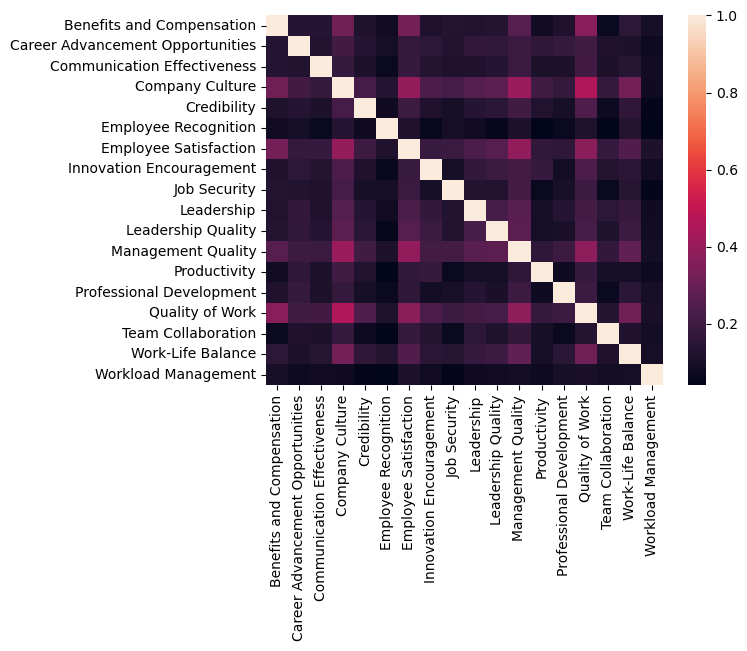

In [65]:
cm = nlp_rolling_ratings.filter(like='12_').filter(like='_mean')
cm.columns = cm.columns.str.removeprefix('12_').str.removesuffix('_mean')
cm = cm.corr()

sns.heatmap(cm)